# PrivacyNet on MNIST data.

In [1]:
import numpy as np
from keras.datasets import mnist
import random

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.convolutional import UpSampling2D
from keras.layers import Conv2D, MaxPooling2D,LeakyReLU,Conv2DTranspose
from keras.layers import Input, Lambda, concatenate, Add, Concatenate
from keras import backend as K

from keras.optimizers import Adam, RMSprop

In [4]:
from privacy_net.utils.module import u_tail
from privacy_net.utils.module import y_tail
from privacy_net.utils.module import InstanceNormalization2D
from privacy_net.utils.module import residual_block
from privacy_net.models.privacy_net_model import privacyNet

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def generator(img):
    #     def tileAttr(x):
    #         x = tf.expand_dims(x, axis = 1)
    #         x = tf.expand_dims(x, axis = 2)
    #         return tf.tile(x, [1, size, size, 1])

    #     y = Concatenate()([img, Lambda(tileAttr)(attr)])

    y = Conv2D(32, 5, padding="same", kernel_initializer='he_normal')(img)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(64, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(128, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)

    y = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2DTranspose(32, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = Activation('tanh')(y)
    return y

In [6]:
def discriminator(img, u_size, y_size, u_feat_dims=None, y_feat_dims=None, activation='tanh'):

    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)

    pred_f_u = []
    if not u_feat_dims:
        u_feat_dims = [2 for _ in range(u_size)]
        
    pred_f_y = []
    if not y_feat_dims:
        y_feat_dims = [2 for _ in range(y_size)]

    for i in range(u_size):
        temp_u = Conv2D(u_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_u = Flatten()(temp_u)
        pred_f_u.append(temp_u)
        
    for i in range(y_size):
        temp_y = Conv2D(y_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_y = Flatten()(temp_y)
        pred_f_y.append(temp_y)

    return pred_f_u,pred_f_y

In [7]:
def generatorV2(img):

    
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='relu')(trans_x)
    trans_x = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(trans_x)
    trans_x = Activation('tanh')(trans_x)
    return trans_x

In [8]:
def generatorV3(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='tanh')(trans_x)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [9]:
def generatorV4(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(96, kernel_size=3,
                         padding='same',
                         activation='tanh')(img)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [10]:
def save_some(im_list,name):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.savefig(name)

# Reversed digits experiment

In [11]:
class reversedMNISTGenerator():
    def __init__(self, batch_size=16):

        self.input_shape = (28, 28, 1)
        self.batch_size = batch_size
        (self.x_train, self.digit_train), (self.x_test, self.digit_test) = mnist.load_data()
        self.x_train = np.expand_dims(self.x_train, axis=-1)
        self.x_test = np.expand_dims(self.x_test, axis=-1)
        
        self.x_train = np.concatenate((self.x_train,255-self.x_train),axis=0)
        self.x_test = np.concatenate((self.x_test,255-self.x_test),axis=0)
        self.digit_train = np.concatenate((self.digit_train,self.digit_train),axis=0)
        self.digit_test = np.concatenate((self.digit_test,self.digit_test),axis=0)
        
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        
        self.u_train, self.u_test = self.load_public_label()
        self.y_train, self.y_test = self.load_sensitive_label()
        
        self.steps_per_epoch = self.default_training_steps
        self.test_steps = self.default_testing_steps

        self.cur_train_step = 0
        self.cur_test_step = 0
        self.train_ind_list = np.array([i for i in range(self.train_size)])
        self.test_ind_list = np.array([i for i in range(self.test_size)])
        random.seed(1234)
        random.shuffle(self.train_ind_list)
        random.shuffle(self.test_ind_list)

    # property is a getter
    @property
    def default_training_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.train_size / self.batch_size))

    @property
    def default_testing_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.test_size / self.batch_size))

    def load_public_label(self):
        # prepare utility labels
#         u_train = np.zeros_like(self.digit_train)
#         u_test = np.zeros_like(self.digit_test)

#         u_train[self.digit_train % 2 == 1] = 1
#         u_test[self.digit_test % 2 == 1] = 1

        return self.digit_train, self.digit_test

    def load_sensitive_label(self):
        # prepare privacy labels
        y_train = np.zeros_like(self.digit_train)
        y_test = np.zeros_like(self.digit_test)
        
        y_train[int(self.train_size/2):] = 1
        y_test[int(self.test_size/2):] = 1
        return y_train, y_test

    def nextTrain(self):
        while True:

            # set self.cur_train_ind
            # cur_train_ind has indices of batch_sizes, this indices correpond to the image ids
            self.fetchCurrentTrainInd()
            train_x = self.x_train[self.cur_train_ind]
            train_x = train_x / 127.5 - 1

            train_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                train_u[i][self.u_train[self.cur_train_ind[i]]] = 1
            train_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                train_y[i][self.y_train[self.cur_train_ind[i]]] = 1

            inputs = {'input_x': train_x, 'input_y': [train_y], 'input_u': [train_u]}
            output = np.zeros((self.batch_size, 1))
            self.cur_train_step += 1
            yield inputs, output

    def fetchCurrentTrainInd(self):
        # this function find cur_train_ind for each step
        # it read batch_size's image_ids, starting from cur_train_step(batch_size,augment_ratio)

        # if self.cur_train_step%self.augment_ratio != 0:
        #     return

        # when epoch end it will shuffle image_ids and reset cur_train_step, namely, read from the start
        if self.cur_train_step >= self.steps_per_epoch:
            random.shuffle(self.train_ind_list)
            # print("shuffling")
            self.cur_train_step = 0

        cur_train_start = int(self.cur_train_step) * self.batch_size
        cur_train_end = cur_train_start + self.batch_size
        if cur_train_end > self.train_size:
            cur_train_end = self.train_size
        self.cur_train_ind = self.train_ind_list[np.arange(cur_train_start, cur_train_end).astype(int)]

    def nextVal(self):
        while True:
            if self.cur_test_step == self.test_steps:
                self.cur_test_step = 0
                random.shuffle(self.test_ind_list)
            cur_test_start = int(self.cur_test_step) * self.batch_size
            cur_test_end = cur_test_start + self.batch_size
            if cur_test_end > self.test_size:
                cur_test_end = self.test_size
            self.cur_test_ind = self.test_ind_list[np.arange(cur_test_start, cur_test_end)]

            test_x = self.x_test[self.cur_test_ind]
            test_x = test_x / 127.5 - 1

            test_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                test_u[i][self.u_test[self.cur_test_ind[i]]] = 1
            test_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                test_y[i][self.y_test[self.cur_test_ind[i]]] = 1

            self.cur_test_step += 1
            inputs = {'input_x': test_x, 'input_y': [test_y], 'input_u': [test_u]}
            output = np.zeros((self.batch_size, 1))
            yield inputs, output

In [15]:
class privacyNetV4(privacyNet):

    def __init__(self, u_input_dims=[2, 2, 2, 2], y_input_dims=[2], u_feat_dims=[2, 2, 2, 2], y_feat_dims=[2],mode=0,
                 **kwargs):
        self.u_input_dims = u_input_dims
        self.y_input_dims = y_input_dims
        self.u_feat_dims = u_feat_dims
        self.y_feat_dims = y_feat_dims
        self.mode = mode # 0->generatorV2 1->generatorV3 2->generatorV4
        super(privacyNetV4, self).__init__(**kwargs)

    def build_model(self):

        """Build Discriminator and Generator and Transformer, seperately.
        This method requires no inputs and returns nothing.
        self.d_model, self.g_model, self.transform_tail_models are goals for this method.
        NOTE: The following 'Output's and 'Input's are used for introducing model specs.

        # D model arguments:
            - d_model: Discriminator part.
        Input:
            - attr_y_input: list of Input Tensors. sensitive labels, Y.
            - attr_u_input(Optional): list, of Input Tensors. public labels, U.
            - img_input: Input Tensor, shared with g_model. raw images, X.
        Output:
            - loss_y_output: list, H-score between imgs and sensitive labels. H_score.
            - loss_u_output: list, H-score between imgs and public labels. Might be None. H_score
            - pred_real: predictions of real images. prob.
            - pred_f_y: list,feature of Y. y(X).
            - pred_f_u: list,feature of U. u(X).

        # G model:
            - g_model: Generator part.
        Input:
            - img_input: Input Tensor, shared with d_model. raw images, X.
        Output:
            - img_output: transformed images. transformed images, Z.

        # T models:
            - transform_tail_models: list of T models.
        Input:
            - transform_y_input: list of input of third networks in order to filter
                                 sensitive information. y(Z)
        Output:
            - transform_y_tail: list. h(y(Z))

        """
        ################## Part I ######################
        ## start building D model
        self.img_input = Input(self.image_size)
        self.attr_y_input = []  # placeholder for every sensitive labels
        self.attr_u_input = []  # placeholder for every public labels

        for i in range(self.y_size):
            self.attr_y_input.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u_input.append(Input((self.u_input_dims[j],)))

        self.pred_f_u, _ = discriminator(self.img_input,
                                                     self.u_size,
                                                     0,
                                                     self.u_feat_dims,
                                                     activation=self.activation)
        _, self.pred_f_y = discriminator(self.img_input,
                                                     0,
                                                     self.y_size,
                                                     self.y_feat_dims,
                                                     activation=self.activation)
        # All tail networks are separated
        self.attr_y_tail = []  # holding tails network for sensitive_attrs
        self.attr_u_tail = []  # holding tails network for public_attrs

        for i in range(self.y_size):
            self.attr_y_tail.append(y_tail(self.attr_y_input[i],
                                           self.y_feat_dims[i],
                                           activation=self.activation))

        for j in range(self.u_size):
            self.attr_u_tail.append(u_tail(self.attr_u_input[j],
                                           self.u_feat_dims[j],
                                           activation=self.activation))

        self.loss_y_output = []  # containing sensitive H-score
        self.loss_u_output = []  # containing public H-score

        for i in range(self.y_size):
            self.loss_y_output.append(Lambda(self.neg_hscore)([self.pred_f_y[i], self.attr_y_tail[i]]))

        for j in range(self.u_size):
            self.loss_u_output.append(Lambda(self.neg_hscore)([self.pred_f_u[j], self.attr_u_tail[j]]))

        self.d_model = Model(inputs=[self.img_input] + self.attr_u_input + self.attr_y_input,
                             outputs= self.loss_u_output + self.loss_y_output
                                     + self.pred_f_u + self.pred_f_y)
        if self.d_model_dir:
            self.d_model.load_weights(self.d_model_dir)  # load pretrained model if avialable
        ## end building D model
        self.d_model.summary()

        ################## Part II ######################
        ## start building G model
        if self.mode == 0:
            self.img_output = generatorV2(self.img_input)  # pass image into generator
        elif self.mode == 1:
            self.img_output = generatorV3(self.img_input)  # pass image into generator
        elif self.mode == 2:
            self.img_output = generatorV4(self.img_input)  # pass image into generator
        else:
            self.img_output = generator(self.img_input)  # pass image into generator
            
        self.g_model = Model(inputs=[self.img_input], outputs=[self.img_output])

        if self.g_model_dir:
            self.g_model.load_weights(self.g_model_dir)  # load pretrained model if avialable
        ## end building G model
        self.g_model.summary()


    def build_loss(self):
        """Build Discriminator and Generator and Transformer loss, itegrating G,D,T into privacy_net model.
        This project uses three steps training, D->T->G. Thus, three losses are introduced accordingly.

        # Network Arguments:

            - img_a: Input Tensor. Raw images.
            - attr_y: list, Input Tensors. Sensitive labels.
            - attr_u: list, Input Tensors. Public labels.
            - img_a_trans: Output Tensor of G. Transformed images.
            - pred_real(local): List, Output tensor of D. On raw images.
            Details: pred_real
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
            - pred_trans(local): List, Output tensor of D. On transformed images.
            Details: pred_trans
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(Z)                  |               y(Z)                  |
            - h_z(local): list, Output Tensors of T. h(y(Z)).
        """

        # Same implementation with neg_hscore, in case of mixing up with Lambda layer.
        def neg_hscore_loss(x):
            """
            neg hscore loss implementation
            """
            f = x[0]
            g = x[1]
            f0 = f - K.mean(f, axis=0)
            g0 = g - K.mean(g, axis=0)
            corr = tf.reduce_mean(tf.reduce_sum(tf.multiply(f0, g0), 1))
            cov_f = K.dot(K.transpose(f0), f0) / K.cast(K.shape(f0)[0] - 1, dtype='float32')
            cov_g = K.dot(K.transpose(g0), g0) / K.cast(K.shape(g0)[0] - 1, dtype='float32')
            return - corr + tf.trace(K.dot(cov_f, cov_g)) / 2

        ########### Part 0 ################
        ## Connecting three models
        self.img_a = Input(shape=self.image_size)  # Raw images tensor.

        self.attr_y = []  # sensitive_label tensor.
        self.attr_u = []  # public_label tensor.
        for i in range(self.y_size):
            self.attr_y.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u.append(Input((self.u_input_dims[j],)))

        self.img_a_trans = self.g_model(self.img_a)  # Transformed image Tensor.
        pred_trans = self.d_model([self.img_a_trans] + self.attr_u + self.attr_y)  # D output tensor.

        ## end Connecting three models

        ############## Part I #################
        ## build D loss
        # compute u_loss in total
        for i in range(self.u_size):
            if i == 0:
                d_loss_u_total = pred_trans[i]
            else:
                d_loss_u_total += pred_trans[i]

        # compute y_loss in total
        for j in range(self.u_size, self.u_size + self.y_size):
            if j == self.u_size:
                d_loss_y_total = pred_trans[j]
            else:
                d_loss_y_total += pred_trans[j]

        # d_loss = u_loss+y_loss+loss_real+loss_fake+loss_gp
        if self.u_size == 0:
            self.d_loss = (1. / self.y_size) * self.gamma * d_loss_y_total
        else:
            self.d_loss = (1 / self.u_size) * d_loss_u_total + (1. / self.y_size) * self.gamma * d_loss_y_total
        ## end build D loss

        ############## Part II #################
        ## build G

        g_loss_y_total = d_loss_y_total
        g_loss_u_total = d_loss_u_total
        
        if self.u_size == 0:
            self.g_loss = - (1. / self.y_size) * self.gamma * g_loss_y_total
        else:
            self.g_loss = (1. / self.u_size) * g_loss_u_total - (1. / self.y_size) * self.gamma * g_loss_y_total
        ## end build G loss


        # save list for detail printing.
        self.d_loss_list_print = []
        if self.u_size > 0:
            self.d_loss_list_print.append(d_loss_u_total)
        self.d_loss_list_print.append(d_loss_y_total)

        self.g_loss_list_print = []
        if self.u_size > 0:
            self.g_loss_list_print.append(g_loss_u_total)
        self.g_loss_list_print.append(g_loss_y_total)

    def build_optimizer(self):

        self.g_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.g_model.trainable_weights, [], self.g_loss)
        self.g_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.g_loss_list_print, self.g_training_updates)


        self.d_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.d_model.trainable_weights, [], self.d_loss)
        self.d_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.d_loss_list_print,
                                  self.d_training_updates)
    def build_output(self):
        pass
    
    def train(self):
        dict_val, _ = next(self.celeba_generator.nextVal())
        sample_input_x = dict_val['input_x']
        save_some(sample_input_x[:10], os.path.join(self.log_dir, 'original_image'))
        loss_g = []
        loss_d = []
        for j in range(self.start_epoch, self.num_epochs):
            # clean up loss logs on epoch begin, loss list different when u_size = 0
            for i in range(self.celeba_generator.steps_per_epoch):
                dict_input, output = next(self.celeba_generator.nextTrain())
#                 output = output.reshape(self.batch_size)
                input_x = dict_input['input_x']
                input_y = dict_input['input_y']
                input_u = dict_input['input_u']
                input_y_batch = []
                input_u_batch = []
                for ind_1 in range(self.y_size):
                    input_y_batch.append(input_y[ind_1])
                for ind_2 in range(self.u_size):
                    input_u_batch.append(input_u[ind_2])
                for _ in range(self.d_ites):
                    errD = self.d_train([input_x] + input_u_batch + input_y_batch)
                errT = []
                for _ in range(self.g_ites):
                    errG = self.g_train([input_x] + input_u_batch + input_y_batch)

                if i % 50 == 0:
                    if self.u_size > 0:
                        print(
                            'epoch{}/{},batch:{}/{},loss_u D:{},loss_y D:{},loss_u G:{},loss_y G:{}'.
                                format(j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                       np.mean(errD[0]), np.mean(errD[1]), np.mean(errG[0]), np.mean(errG[1])))
                    else:
                        print(
                            'epoch{}/{},batch:{}/{},loss_y D:{},loss_y G:{}'.
                                format(j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                       np.mean(errD[0]), np.mean(errG[0]),
                                       ))

                    loss_d.append(np.mean(errD))
#                     for ind_1 in range(len(d_loss_list)):
#                         loss_d[ind_1 + 1].append(np.mean(d_loss_list[ind_1]))

                    loss_g.append(np.mean(errG))
#                     for ind_2 in range(len(g_loss_list)):
#                         loss_g[ind_2 + 1].append(np.mean(g_loss_list[ind_2]))

#                     loss_t.append(np.mean(errT))

                if i % 1000 == 0:
                    val_trans_x = self.g_model.predict(sample_input_x)
                    save_some(val_trans_x[:10], os.path.join(self.log_dir, 'predict_' + str(j) + '_' + str(i)))

            if (j+1) % 5 == 0:
                self.g_model.save_weights(os.path.join(self.log_dir, 'g_model_' + self.date + '_' + str(j) + '.h5'))
                self.d_model.save_weights(os.path.join(self.log_dir, 'd_model_' + self.date + '_' + str(j) + '.h5'))
        results_loss = {}
        results_loss['d_loss'] = loss_d
        results_loss['g_loss'] = loss_g
        np.save(os.path.join(self.log_dir, 'result_loss_' + self.date + '_' + str(j) + '.npy'), results_loss)



In [16]:
import os
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
batch_size = 16
K.set_learning_phase(False)
set_session(tf.Session())

In [ ]:
# for gamma in [0.01,0.1,1,10]:
#     for ind_mode in range(3):
gamma = 1
ind_mode = 0
log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
mnist_generator = reversedMNISTGenerator()
privacy_net = privacyNetV4(log_dir=log_dir,
                           g_model_dir=None,
                           d_model_dir=None,
                           start_epoch=0,
                           batch_size=batch_size,
                           image_size=(28, 28, 1),
                           data_generator = mnist_generator,
                           u_input_dims=[10],
                           u_feat_dims=[10],
                           y_feat_dims=[2],
                           u_size = 1,
                           mode=ind_mode,
                           epochs=1, lambda_cls=1,
                           gamma=gamma, activation='tanh',t_ites =1)
privacy_net.train()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

epoch0/1,batch:0/7500,loss_u D:0.005318072624504566,loss_y D:0.0006622052751481533,loss_u G:0.0010747205233201385,loss_y G:-0.0064501892775297165
epoch0/1,batch:50/7500,loss_u D:0.0005219738814048469,loss_y D:-0.051685236394405365,loss_u G:-0.0017082436243072152,loss_y G:-0.05822570621967316
epoch0/1,batch:100/7500,loss_u D:-0.011824860237538815,loss_y D:0.003541097044944763,loss_u G:-0.01465501356869936,loss_y G:-0.004309161100536585
epoch0/1,batch:150/7500,loss_u D:-0.02114739455282688,loss_y D:-0.07812657952308655,loss_u G:-0.02385328710079193,loss_y G:-0.08633303642272949
epoch0/1,batch:200/7500,loss_u D:-0.01921435259282589,loss_y D:0.04146914929151535,loss_u G:-0.021759560331702232,loss_y G:0.036060985177755356
epoch0/1,batch:250/7500,loss_u D:-0.08430233597755432,loss_y D:-0.015035433694720268,loss_u G:-0.09057803452014923,loss_y G:-0.032853592187166214
epoch0/1,batch:300/7500,loss_u D:-0.23813560605049133,loss_y D:0.02158321440219879,loss_u G:-0.250367134809494,loss_y G:0.00588

epoch0/1,batch:2900/7500,loss_u D:-1.2453293800354004,loss_y D:-0.03752651810646057,loss_u G:-1.280495524406433,loss_y G:-0.046976618468761444
epoch0/1,batch:2950/7500,loss_u D:-1.603892207145691,loss_y D:-0.014985211193561554,loss_u G:-1.6196954250335693,loss_y G:-0.02404061332345009
epoch0/1,batch:3000/7500,loss_u D:-1.6716405153274536,loss_y D:0.010600415989756584,loss_u G:-1.697558879852295,loss_y G:0.004154987633228302
epoch0/1,batch:3050/7500,loss_u D:-1.669593334197998,loss_y D:-0.03006819635629654,loss_u G:-1.6867749691009521,loss_y G:-0.03651800751686096
epoch0/1,batch:3100/7500,loss_u D:-1.0314171314239502,loss_y D:0.0023334084544330835,loss_u G:-1.085890293121338,loss_y G:-0.005083288997411728
epoch0/1,batch:3150/7500,loss_u D:-1.5504772663116455,loss_y D:-0.006110033951699734,loss_u G:-1.580320119857788,loss_y G:-0.014232256449759007
epoch0/1,batch:3200/7500,loss_u D:-1.3994600772857666,loss_y D:-0.011253904551267624,loss_u G:-1.4298256635665894,loss_y G:-0.0193947404623031

epoch0/1,batch:5800/7500,loss_u D:-1.528921365737915,loss_y D:0.0040728868916630745,loss_u G:-1.5708703994750977,loss_y G:-0.00013581966049969196
epoch0/1,batch:5850/7500,loss_u D:-1.6239588260650635,loss_y D:-0.00927053764462471,loss_u G:-1.6519362926483154,loss_y G:-0.015528603456914425
epoch0/1,batch:5900/7500,loss_u D:-1.5458506345748901,loss_y D:0.0022302826400846243,loss_u G:-1.570481538772583,loss_y G:-0.0035071459133177996
epoch0/1,batch:5950/7500,loss_u D:-1.5007250308990479,loss_y D:-0.005030801519751549,loss_u G:-1.5428752899169922,loss_y G:-0.010358000174164772
epoch0/1,batch:6000/7500,loss_u D:-1.6008236408233643,loss_y D:0.013754269108176231,loss_u G:-1.6405205726623535,loss_y G:0.007548164576292038
epoch0/1,batch:6050/7500,loss_u D:-1.4177465438842773,loss_y D:0.020975785329937935,loss_u G:-1.5067312717437744,loss_y G:0.014843343757092953
epoch0/1,batch:6100/7500,loss_u D:-2.0684127807617188,loss_y D:-0.002698109485208988,loss_u G:-2.0739567279815674,loss_y G:-0.00922228

# compare three generators

In [22]:
def plot_some(im_list):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.close()
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.show()

In [26]:
import os
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
batch_size = 16
K.set_learning_phase(False)

set_session(tf.Session())
log_dir = 'logs_mnist_v5_10'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
mnist_generator = evenFiveGenerator()
privacy_net = privacyNetV4(log_dir=log_dir,
                           g_model_dir='logs_mnist_v3_10/g_model_12_19_10.h5',
                           d_model_dir=None,
                           start_epoch=0,
                           batch_size=batch_size,
                           image_size=(28, 28, 1),
                           data_generator = mnist_generator,
                           u_input_dims=[10],
                           u_feat_dims=[10],
                           y_feat_dims=[2],
                           u_size = 1,
                           mode=0,
                           epochs=30, lambda_cls=1,
                           gamma=10, activation='tanh',t_ites =2)


# privacy_net_1 = privacyNetV4(log_dir=log_dir,
#                            g_model_dir='logs_mnist_v4_10/g_model_12_19_10.h5',
#                            d_model_dir=None,
#                            start_epoch=0,
#                            batch_size=batch_size,
#                            image_size=(28, 28, 1),
#                            data_generator = mnist_generator,
#                            u_input_dims=[10],
#                            u_feat_dims=[10],
#                            y_feat_dims=[2],
#                            u_size = 1,
#                            mode=1,
#                            epochs=30, lambda_cls=1,
#                            gamma=10, activation='tanh',t_ites =2)
# privacy_net_2 = privacyNetV4(log_dir=log_dir,
#                            g_model_dir='logs_mnist_v5_10/g_model_12_19_10.h5',
#                            d_model_dir=None,
#                            start_epoch=0,
#                            batch_size=batch_size,
#                            image_size=(28, 28, 1),
#                            data_generator = mnist_generator,
#                            u_input_dims=[10],
#                            u_feat_dims=[10],
#                            y_feat_dims=[2],
#                            u_size = 1,
#                            mode=2,
#                            epochs=30, lambda_cls=1,
#                            gamma=10, activation='tanh',t_ites =2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 14, 14, 32)   0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 1)         1601      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 1)         0         
Total params: 20,417
Trainable params: 20,417
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
lambda_8 (Lambda)            (None, 28, 28, 1)         0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 28, 28, 1)    0                  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 96)        960       
_________________________________________________________________
lambda_11 (Lambda)           (None, 28, 28, 1)         0         
Total params: 960
Trainable params: 960
Non-trainable params: 0
_________________________________________________________________


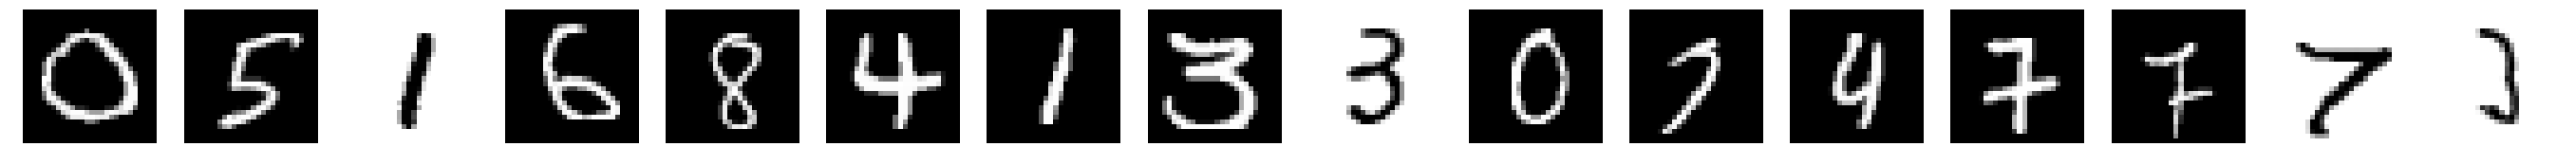

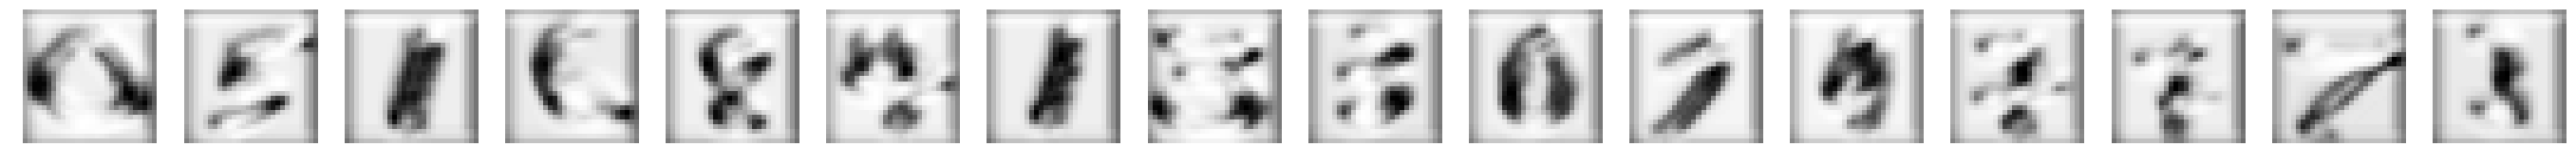

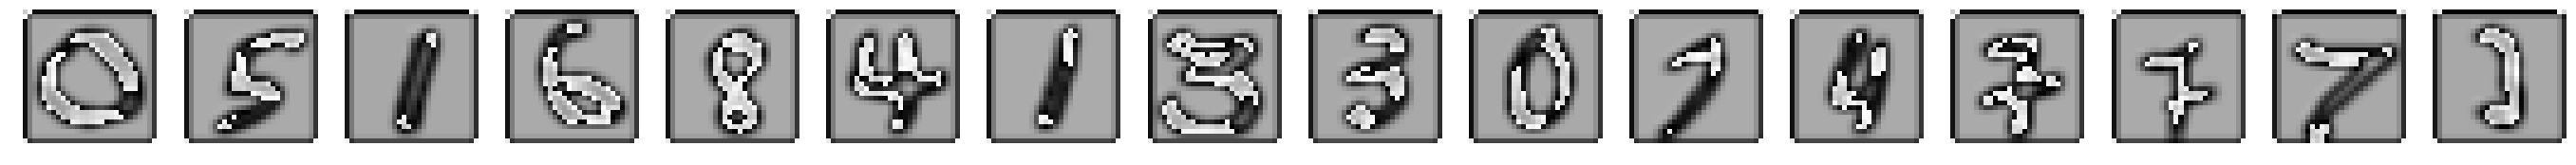

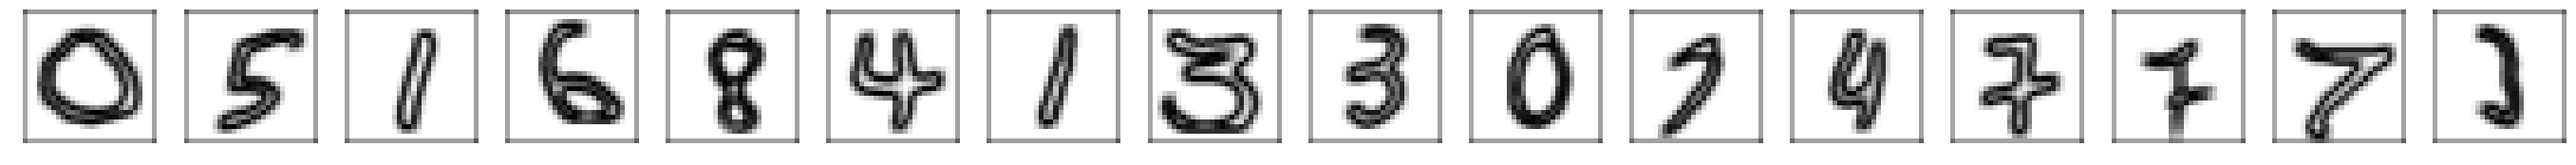

In [72]:
inputs,_ = next(mnist_generator.nextVal())
input_x = inputs['input_x']
trans_x = privacy_net.g_model.predict(input_x)
trans_x_1 = privacy_net_1.g_model.predict(input_x)
trans_x_2 = privacy_net_2.g_model.predict(input_x)
plot_some(input_x)
plot_some(trans_x)
plot_some(trans_x_1)
plot_some(trans_x_2)

In [76]:
trans_x_1[trans_x_1>1] = 1
trans_x_1[trans_x_1<-1] = -1
print_img = []
print_img.append(input_x)
print_img.append(trans_x)
print_img.append(trans_x_1)
print_img.append(trans_x_2)

for ind_row in range(len(print_img)):
    for ind_col in range(len(print_img[0])):
        if ind_col == 0:    
            image_mnist = print_img[ind_row][0]
        else:
            image_mnist = np.concatenate((image_mnist,print_img[ind_row][ind_col]),axis=1)
    if ind_row ==0:
        image_mnists = image_mnist.copy()
    else:
        image_mnists = np.concatenate((image_mnists,image_mnist),axis=0)

In [71]:
ind_row = 0
for ind_col in range(len(print_img[0])):
    if ind_col == 0:    
        image_mnist = print_img[ind_row][0]
    else:
        image_mnist = np.concatenate((image_mnist,print_img[ind_row][ind_col]),axis=1)
plt.imshow(((np.squeeze(image_mnist) + 1) * 127.5).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.savefig('mnist_orig.png',bbox_inches="tight")

In [78]:
import cv2
cv2.imwrite('mnist_images.png',((np.squeeze(image_mnists) + 1) * 127.5).astype(np.uint8))

True

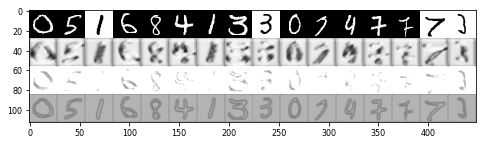

In [79]:
plt.imshow(((np.squeeze(image_mnists) + 1) * 127.5).astype(np.uint8), cmap='gray')
plt.show()